# Goals


The goal of this project is to answer the following questions:
I. EDA
1. How does the change in Doordash's stocks look like over time?
2. Is the change in Doordash's stocks stationary?
3. Are Doordash's stocks autocorrelated?
4. How does the distribution of Doordash's stocks look like?
5. What can we infer from the distribution of Doordash's stocks?

II. Monte Carlo Simulation
1. Using Monte Carlo Simulation, what prices are expected after 1 year of trading?
2. Is holding the stocks for 1 year favorable?

III. Trading Algorithm
1. Construct a trading algorithm based on the idea of Monte Carlo Simulation
2. Hyperparameter tune the functions
3. Test on the real time trading scenario

# Import Libraries

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import shapiro
import numpy as np
from scipy import stats
import warnings
import matplotlib.cm as cm
from scipy.stats import percentileofscore
from scipy.stats import ecdf
from datetime import datetime, timedelta
import math
from sklearn.metrics import accuracy_score
from skopt import gp_minimize
from skopt.space import Real


In [2]:
#Remove any warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis

In [3]:
#Download data for Doordash's stock
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

#Define ticker
ticker = 'DASH'

# Download historical data
data = yf.download(ticker, start="2020-12-09", end="2025-07-03", auto_adjust=True)

# Display the first few rows
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker            DASH        DASH        DASH        DASH      DASH
Date                                                                
2020-12-09  189.509995  195.500000  163.800003  182.000000  25373700
2020-12-10  186.000000  187.695007  172.636002  179.710007   9307600
2020-12-11  175.000000  182.000000  168.250000  176.520004   4760600
2020-12-14  160.000000  170.000000  151.199997  169.100006   7859600
2020-12-15  158.889999  161.419998  153.759995  157.100006   5017000


In [4]:
#Data cleaning

data = data.dropna()

print(data.isnull().sum())

Price   Ticker
Close   DASH      0
High    DASH      0
Low     DASH      0
Open    DASH      0
Volume  DASH      0
dtype: int64


In [5]:
#Flatten the dataframe 
data.columns = data.columns.droplevel(1)  # Drop the first level

#Add daily return
data['Daily Return'] = data['Close'].pct_change()
data = data.dropna(subset=['Daily Return'])

print(data.head())

Price            Close        High         Low        Open   Volume  \
Date                                                                  
2020-12-10  186.000000  187.695007  172.636002  179.710007  9307600   
2020-12-11  175.000000  182.000000  168.250000  176.520004  4760600   
2020-12-14  160.000000  170.000000  151.199997  169.100006  7859600   
2020-12-15  158.889999  161.419998  153.759995  157.100006  5017000   
2020-12-16  158.050003  167.470001  157.199997  161.179993  3061300   

Price       Daily Return  
Date                      
2020-12-10     -0.018521  
2020-12-11     -0.059140  
2020-12-14     -0.085714  
2020-12-15     -0.006938  
2020-12-16     -0.005287  


## Time Series Analysis

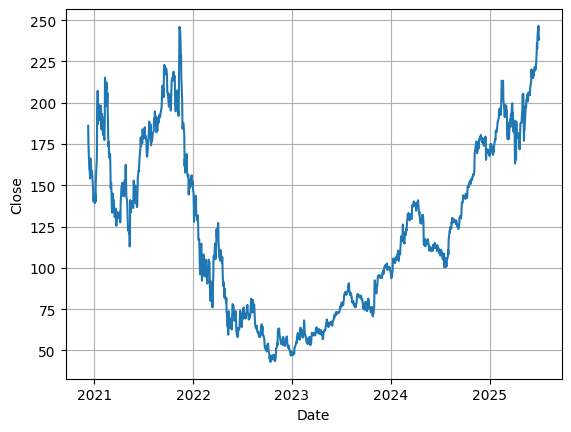

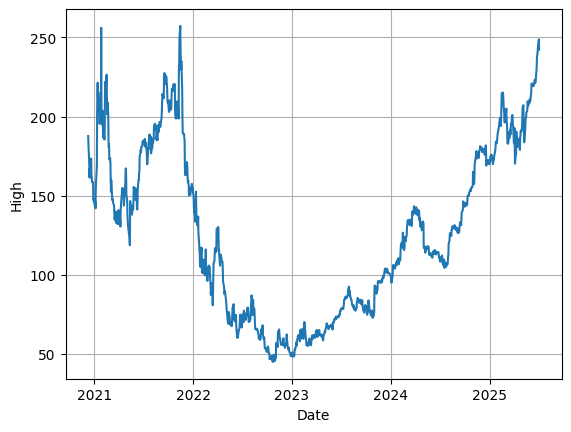

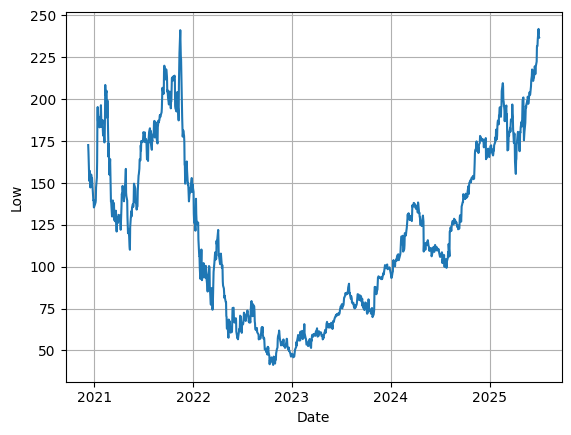

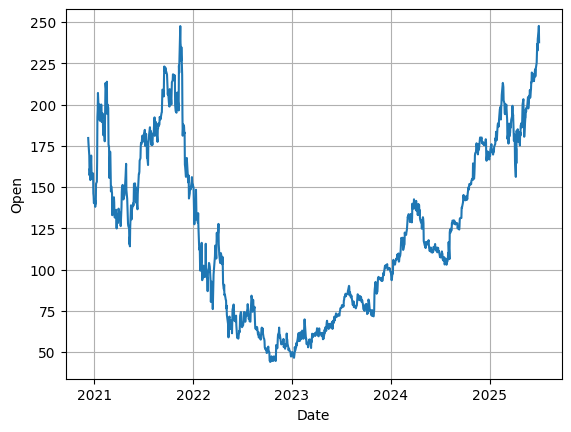

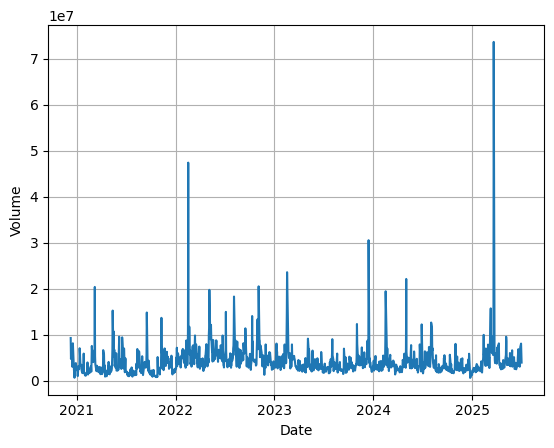

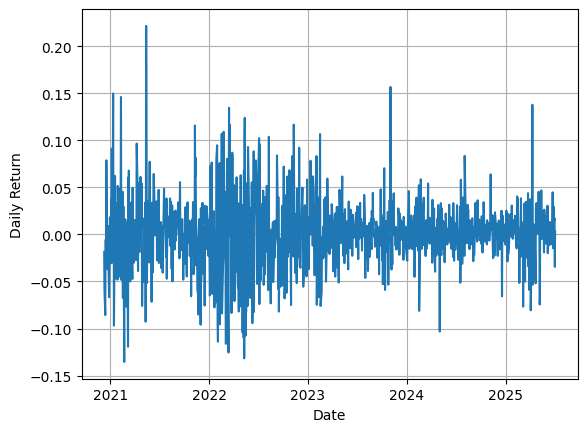

In [6]:
#Line plot the time series of the variables

for col in data.columns:
    plt.plot(data[col])
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

For Close, High, Low, and Open, the prices fluactuated between 125 and 250 for the first year. The values then significantly decreased to less than 50 in 2023, followed by an upward trend in the remaining period. For the Volume, its value showed a dense fluactuation and seasonality in throughout the period. For Daily Return, the values seem to show properties of white noise, constantly fluctuating around 0.

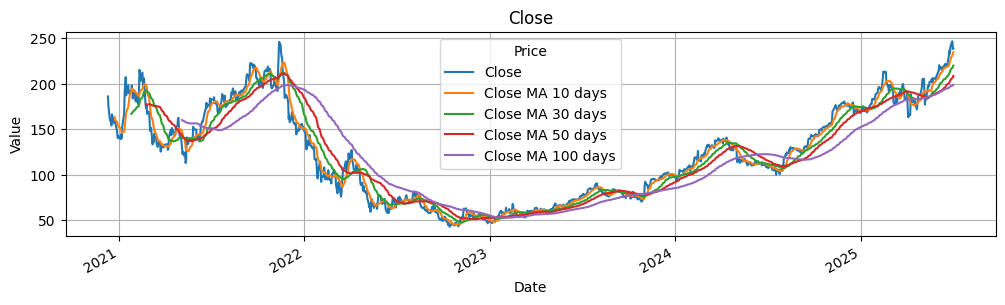

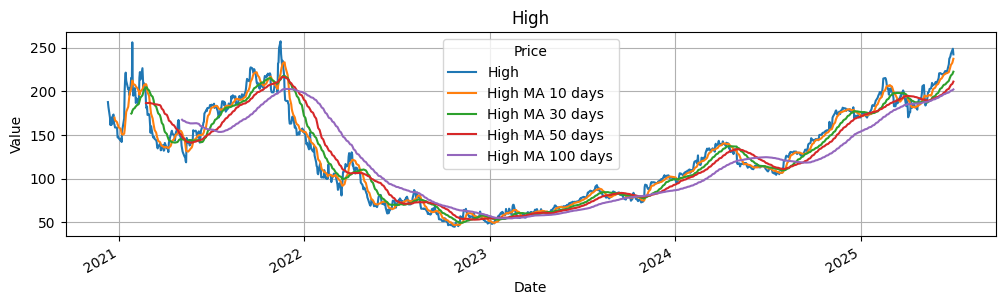

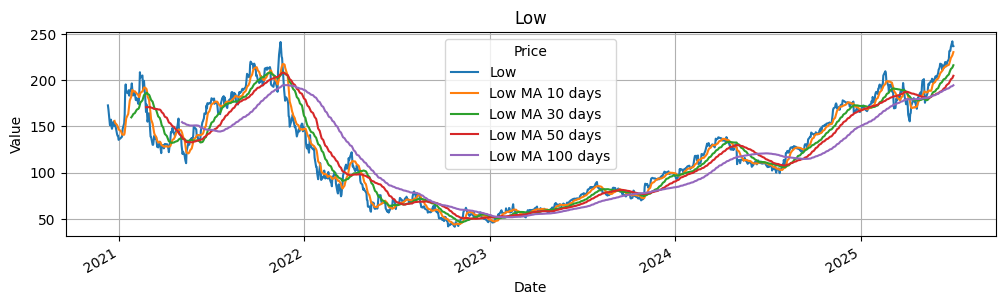

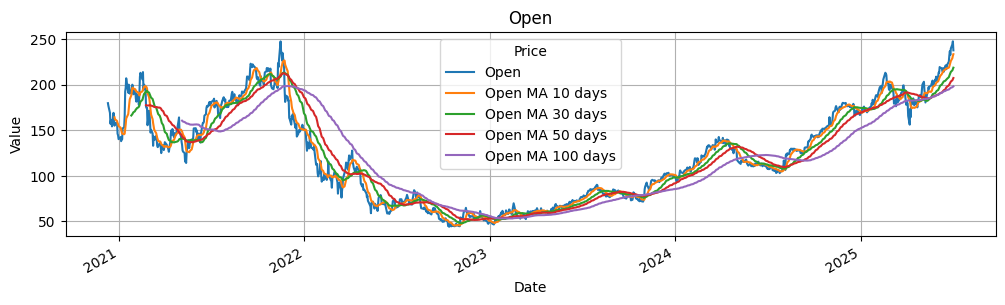

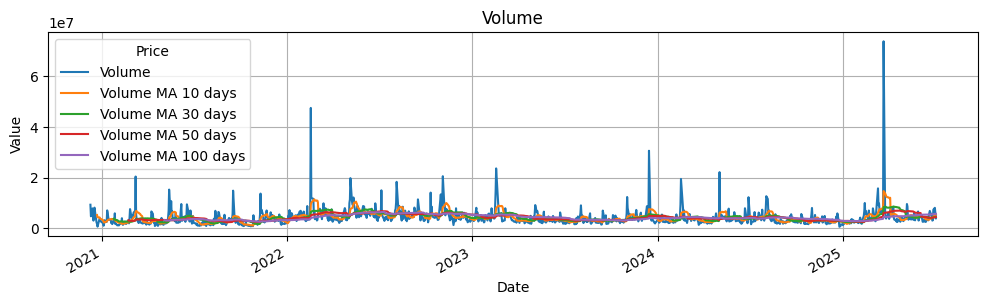

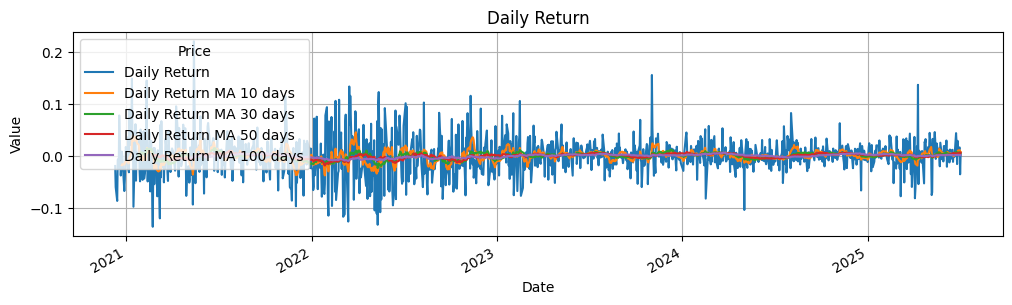

In [7]:
#Line plot the moving averages time series of the variables

ma_day = [10, 30, 50, 100]

for col in data.columns:
    for ma in ma_day:
        column_name = f"{col} MA {ma} days"
        data[column_name] = data[col].rolling(ma).mean()

    # Plot the original column and its 3 MAs
    plot_cols = [col] + [f"{col} MA {ma} days" for ma in ma_day]
    data[plot_cols].plot(figsize=(12, 3), title=col)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

The MAs for CLose, High, Low, and Open follow a smooth curve, increasing from around 150 to 200, followed by a decline to 50 in 2023. The values then rose to 200 at the end of the period. The MAs for Volume and Daily Return on the other hand seem to experience negligible change over the period.

In [8]:
#Drop the MA columns to do analysis on the original dataset
data = data.loc[:, ~data.columns.str.contains('MA')]
data.head()

Price,Close,High,Low,Open,Volume,Daily Return
Date,,,,,,
2020-12-10,186.000000,187.695007,172.636002,179.710007,9307600,-0.018521
2020-12-11,175.000000,182.000000,168.250000,176.520004,4760600,-0.059140
2020-12-14,160.000000,170.000000,151.199997,169.100006,7859600,-0.085714
2020-12-15,158.889999,161.419998,153.759995,157.100006,5017000,-0.006938
2020-12-16,158.050003,167.470001,157.199997,161.179993,3061300,-0.005287


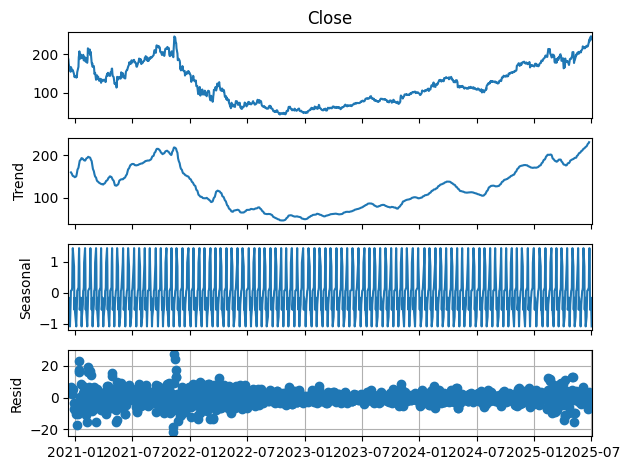

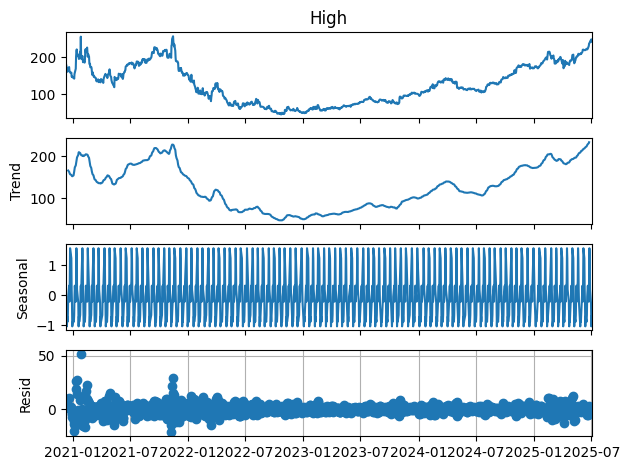

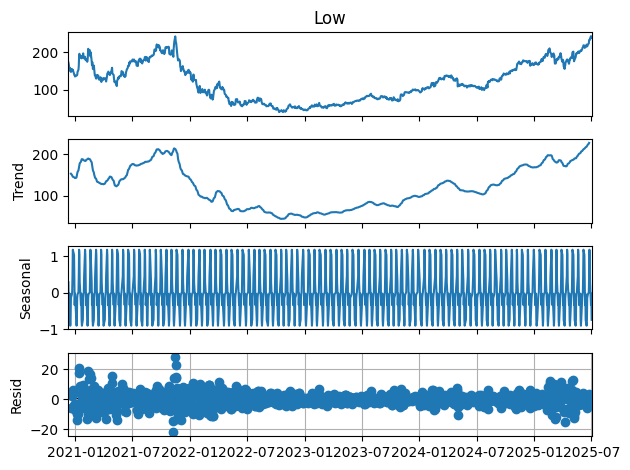

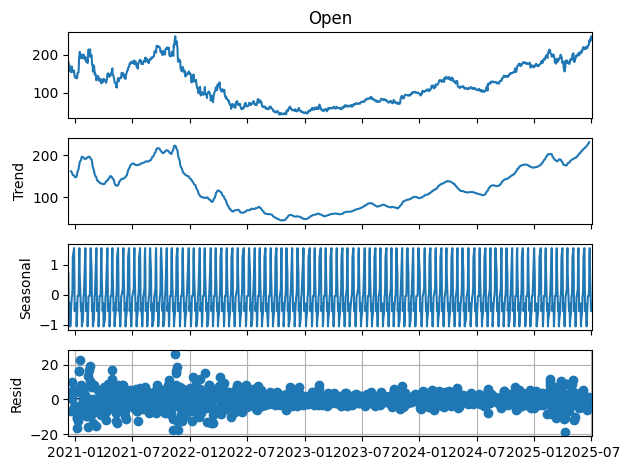

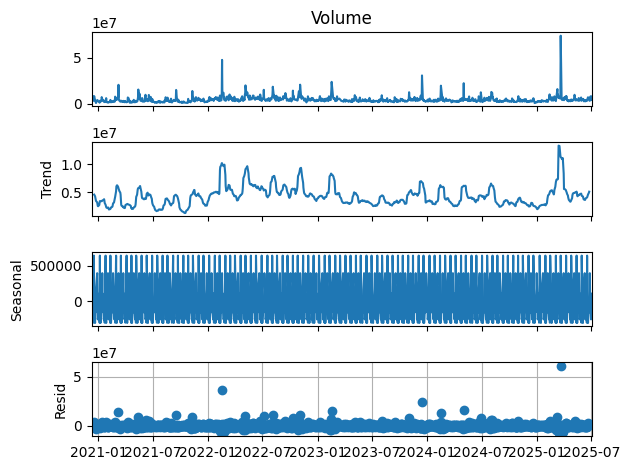

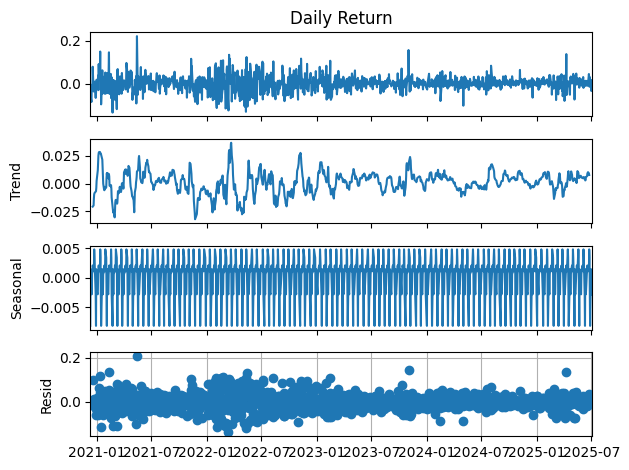

In [9]:
#Visualize trend, seasonality, and residuals

for col in data.columns:
    # Decompose the time series
    result = seasonal_decompose(data[col], model='additive', period=12)  # Adjust period to match your data's seasonality
    
    # Plot the decomposition
    result.plot()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

A time series has a formula: Time Series = Trend + Seasonality + Residuals


All series above show positive trend, suggesting they have increasing values through the period.
All series above show a very tight seasonality, suggesting fast-repeating patterns.
All series above show residuals centered around 0, suggesting randomness and no bias.

In [10]:
#Test for stationarity using ADF test

for col in data.columns:
    print(f"The p-value for {col} is: {adfuller(data[col])[1]}")


The p-value for Close is: 0.7748375847052422
The p-value for High is: 0.8975377734183702
The p-value for Low is: 0.8695127130470828
The p-value for Open is: 0.8184687509176042
The p-value for Volume is: 2.054038177816582e-12
The p-value for Daily Return is: 3.944357135560606e-20


For an ADF test, the null hypothesis (H0) is that the series is non-stationary, and the alternative hypothesis (H1) is that the series is stationary. If the p-value from the ADF test is less than alpha (typically 0.05), the null hypothesis is rejected, meaning the series is stationary, and vice versa. The results from the ADF test show that the series for Close, High, Low, and Open prices are non-stationary (p-values > 0.05), while the series for Volumne and Daily Return is stationary (p-value < 0.05).

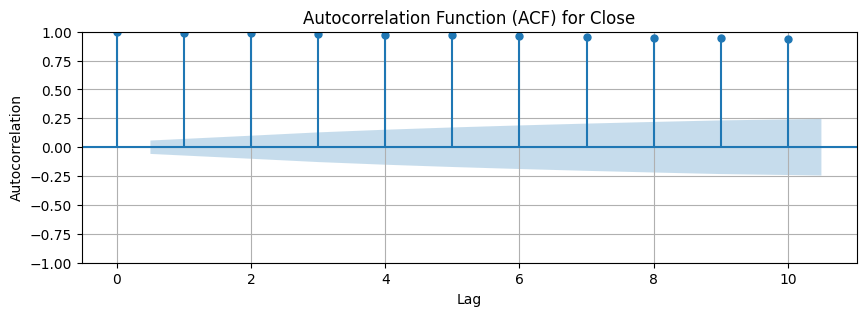

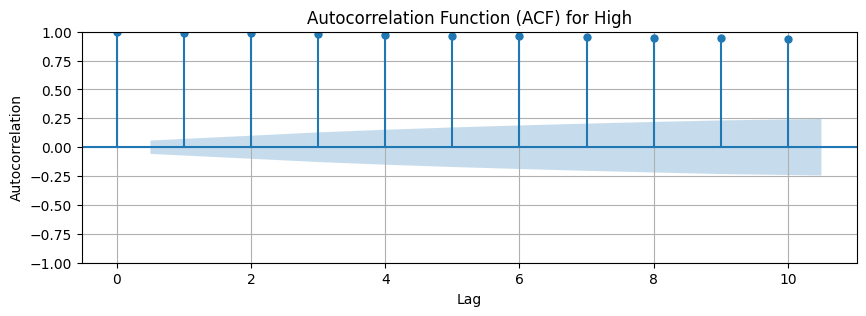

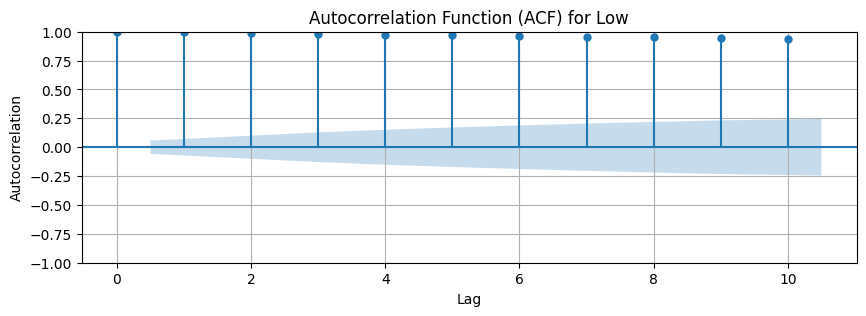

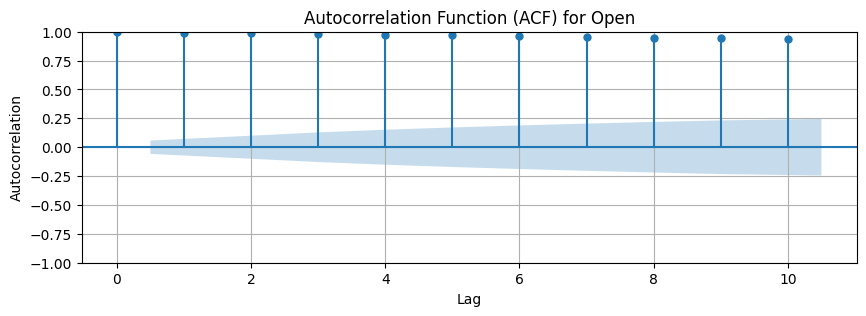

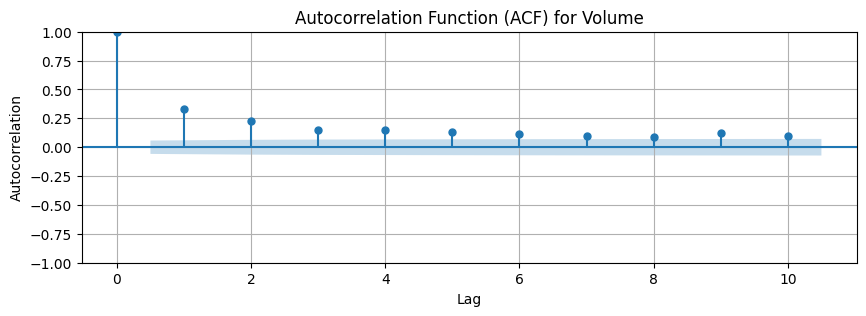

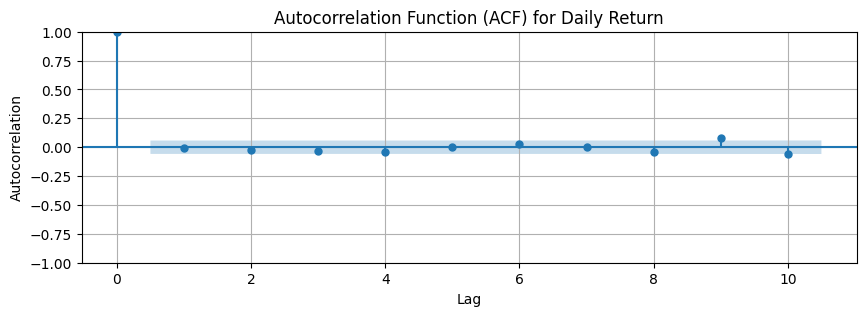

In [11]:
#Visualize autocorrelation

for col in data.columns:
    fig, ax = plt.subplots(figsize=(10, 3))
    plot_acf(data[col], lags=10, ax=ax, alpha=0.05)
    
    # Add title and labels for clarity
    ax.set_title(f'Autocorrelation Function (ACF) for {col}')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    plt.grid(True)
    # Display the plot
    plt.show()

From the ACF plots, all variables except Daily Return seem to express positive autocorrelation, meaning the current values are positively correlated to their lags. Daily Return show no autorcorrelation because the autocorrelation values fluctuate between 0.

In [12]:
#Test for autocorrelation using Durbin-Watson test

for col in data.columns:
    print(f"The Durbin-Watson statistic for {col} is: {durbin_watson(data[col])}")

The Durbin-Watson statistic for Close is: 0.001208272030069383
The Durbin-Watson statistic for High is: 0.0012813241943150865
The Durbin-Watson statistic for Low is: 0.0010376736658361371
The Durbin-Watson statistic for Open is: 0.0012648989447555127
The Durbin-Watson statistic for Volume is: 0.5504020552208571
The Durbin-Watson statistic for Daily Return is: 2.0119414072996875


For a Durbin-Watson test, a statistic of 2, less than 2, and greater than 2 suggests no autocorrelation, positive autocorrelation, and negative autocorrelation, respectively. The results from the Durbin-Watson show that all variables are positively autocorrelated (statistic < 2) except for Daily Return which is approximately non-autocorrelated (statistic = 2) as how the ACF graphs show above, meaning the changes of the adjacent values on the time series are similar (both positive and positive, or both negative and negative). Usually, when a time series shows no autocorrelation, it is considered as white-noise. In this case, those series are not considered white-noise except for Daily Return. 

## Distribution

In [13]:
#Descriptive statistics summary
print(data.describe())

Price        Close         High          Low         Open        Volume  \
count  1144.000000  1144.000000  1144.000000  1144.000000  1.144000e+03   
mean    123.233628   126.099982   120.324379   123.156460  4.267452e+06   
std      51.842964    52.971324    50.838834    51.799034  3.590945e+06   
min      43.060001    44.959999    41.365002    44.000000  6.344000e+05   
25%      75.429998    77.176250    73.257502    75.190002  2.589425e+06   
50%     116.450001   117.919998   113.505001   116.299999  3.513900e+06   
75%     170.887505   174.650005   167.917503   171.432495  5.040950e+06   
max     246.509995   257.250000   241.957993   247.619995  7.363740e+07   

Price  Daily Return  
count   1144.000000  
mean       0.000895  
std        0.037304  
min       -0.135457  
25%       -0.017305  
50%        0.001081  
75%        0.018504  
max        0.221491  


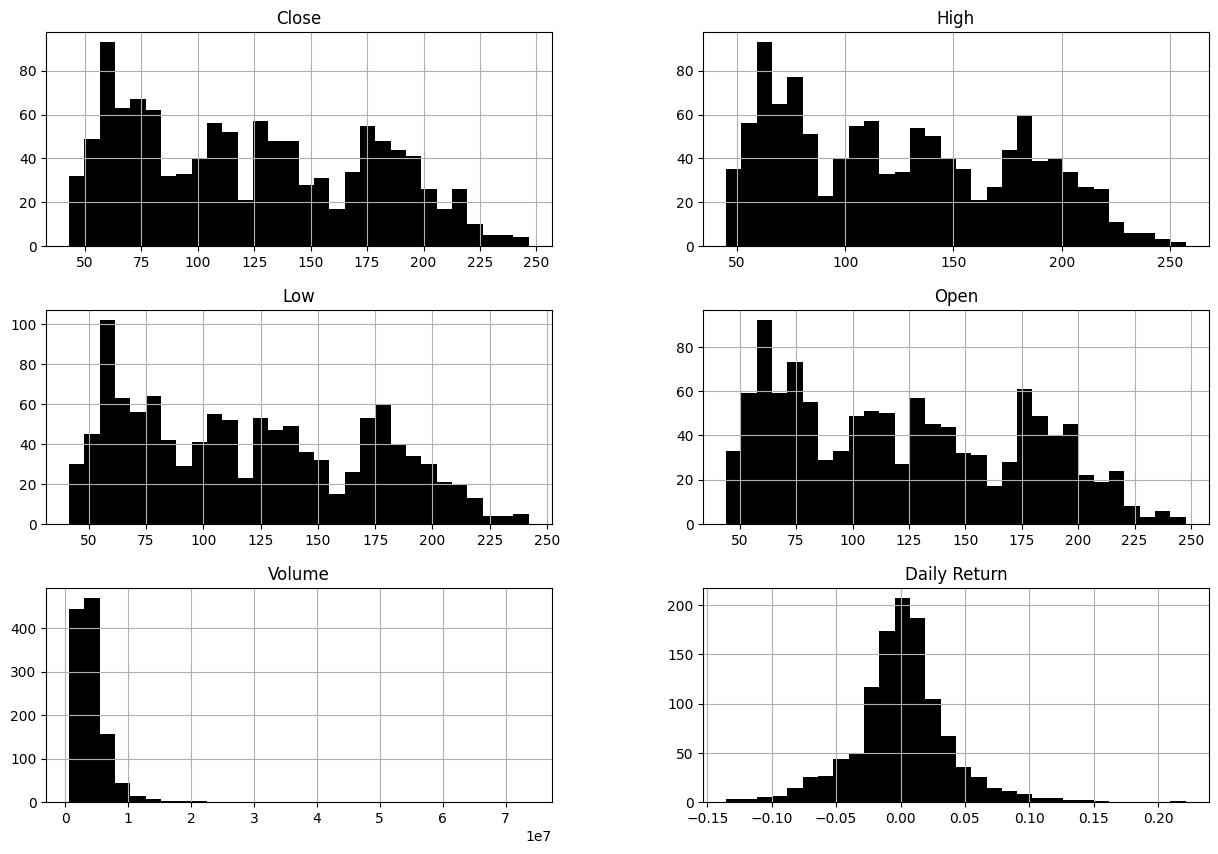

In [14]:
data.hist(color="k",
    bins=30,
    figsize=(15, 10)
)

plt.show()

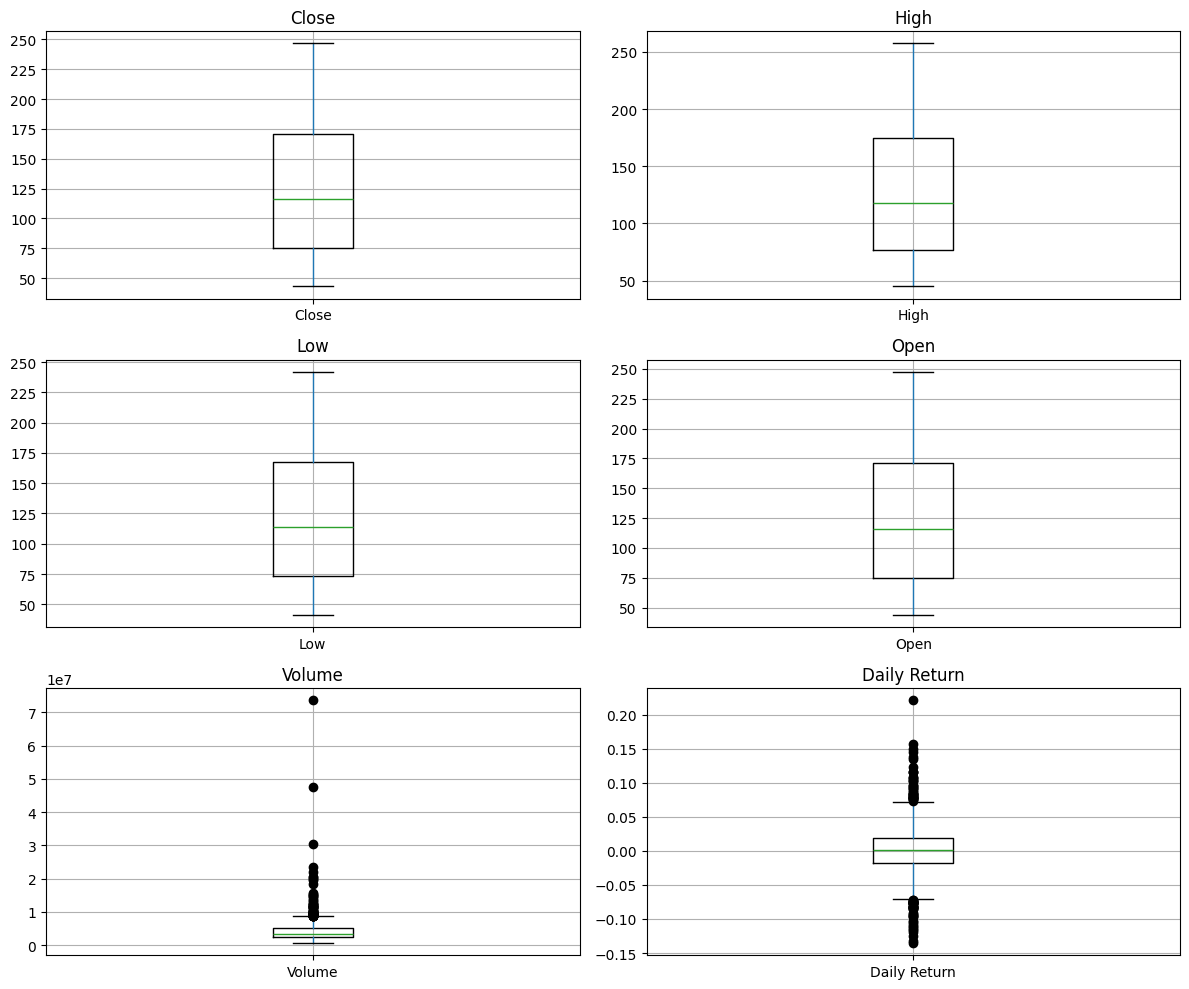

In [15]:
#Box plot

fig, axs = plt.subplots(3, 2, figsize=(12, 10))  # 3 rows x 2 columns grid
axs = axs.flatten()  # Flatten to 1D array for easy indexing

for i, col in enumerate(data.columns):
    data.boxplot(column=col, ax=axs[i], boxprops=dict(color='black'), flierprops=dict(markerfacecolor='black', marker='o'))
    axs[i].set_title(col)

# Hide the last empty plot if you have only 5 columns
if len(data.columns) < len(axs):
    axs[-1].axis('off')

plt.tight_layout()
plt.show()
   

The box plots show that Volume and Daily Return have outliers (represented by the black dots).

In [16]:
#Find the number of outliers using Interquartile range (IQR)
for col in data.columns:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3-q1
    lower_boundary = q1 - 1.5*(iqr)
    upper_boundary = q3 + 1.5*(iqr)
    
    count = 0
    for i in data[col]:
        if i < lower_boundary or i > upper_boundary:
            count+=1
    print(f"There is {count} outliers for {col}.")       

There is 0 outliers for Close.
There is 0 outliers for High.
There is 0 outliers for Low.
There is 0 outliers for Open.
There is 58 outliers for Volume.
There is 82 outliers for Daily Return.


In [17]:
#Test for normality using Shapiro-Wilk test
def is_normal(data):
    stat, p_value = shapiro(data)
    alpha = 0.05

    if p_value > alpha:
        return f"p_value of {col} is {p_value:.50f}. The data for {col} appears to be normally distributed (fail to reject H0)."
    else:
        return f"p_value of {col} is {p_value:.50f}. The data for {col} does not appear to be normally distributed (reject H0)."

for col in data.columns:
    print(is_normal(data[col]))

p_value of Close is 0.00000000000000000003700621336781831150910597272531. The data for Close does not appear to be normally distributed (reject H0).
p_value of High is 0.00000000000000000004436795766209419158576943971158. The data for High does not appear to be normally distributed (reject H0).
p_value of Low is 0.00000000000000000004949475156655400405555044901005. The data for Low does not appear to be normally distributed (reject H0).
p_value of Open is 0.00000000000000000004202364531687357198153669385984. The data for Open does not appear to be normally distributed (reject H0).
p_value of Volume is 0.00000000000000000000000000000000000000000000000365. The data for Volume does not appear to be normally distributed (reject H0).
p_value of Daily Return is 0.00000000000000010282480615793519654119197189333891. The data for Daily Return does not appear to be normally distributed (reject H0).


For a Shapiro-Wilk test, the null hypothesis is that the data is normally distributed, and the alternative hypothesis is that the data is not normally distributed. If the p-value is less than alpha (typically 0.05), the null hypothesis is rejected, meaning the data is not normally distributed, and vice versa. The results from the Shapiro-Wilk test above show that the data for all series are not normally distributed (p-value < 0.05).

### Central Limit Theorem and Statistical Inferences

Since the data for the variables are not normally distributed, the statistical inferences made on them will not be accurate because those inferences such as confidence interval assume the data distribution to be normal. However, thanks to the Central Limit Theorem, we can resample the data into samples of means and assume their distribution is normal. According to the Central Limit Theorem, if we randomly sample the data from a population where each sample has a size of greater than 30, and calculate the means from those samples, the distribution of those means are approximately normal regardless of whether the population distribution is normal or not. 

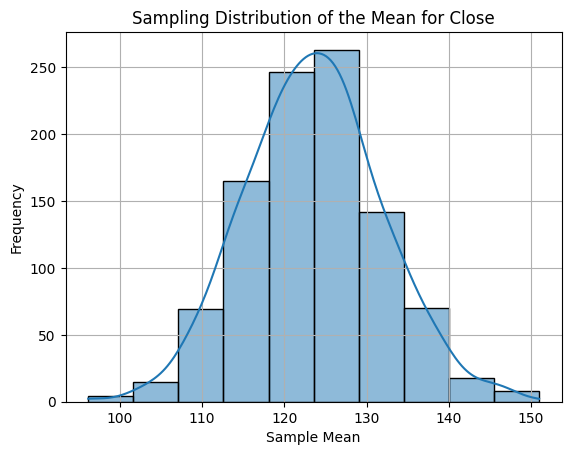

Confidence Interval (95%) of Close: (123.0329334494969, 124.06838653665575)


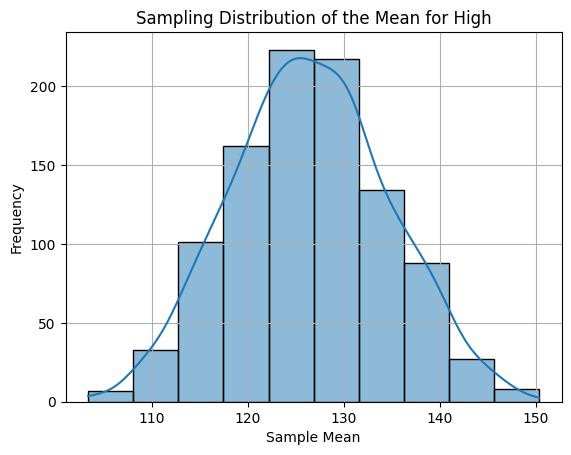

Confidence Interval (95%) of High: (125.94315346832971, 126.9565537769248)


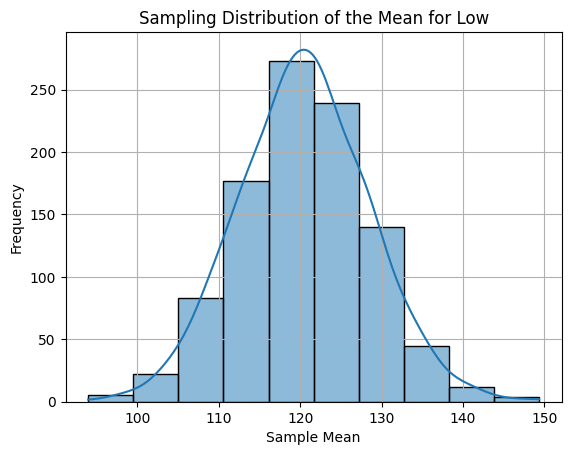

Confidence Interval (95%) of Low: (119.96375360977498, 120.95811021278055)


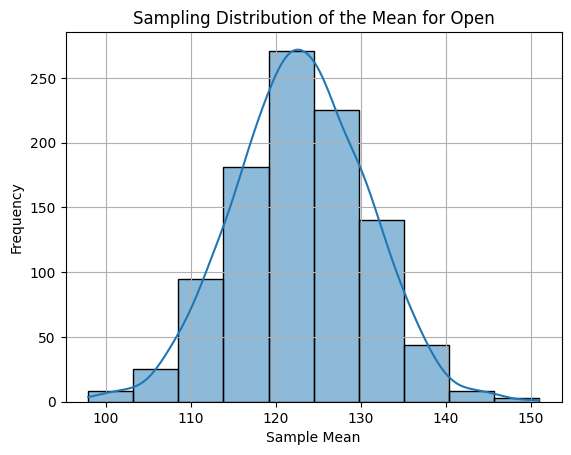

Confidence Interval (95%) of Open: (122.40109241614584, 123.36429926781412)


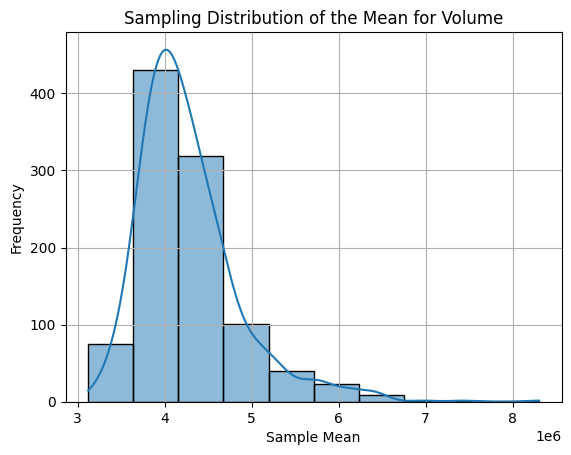

Confidence Interval (95%) of Volume: (4236535.819164572, 4309826.055835428)


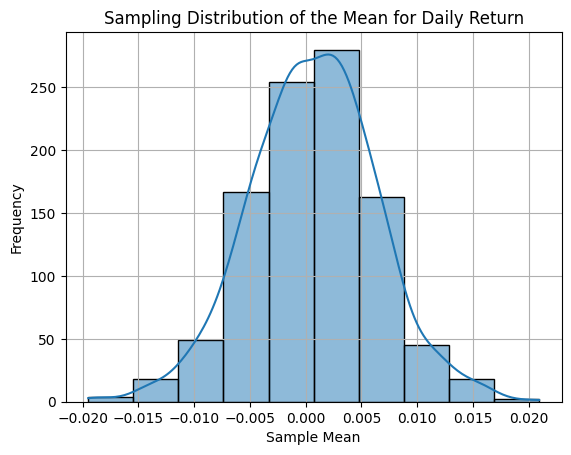

Confidence Interval (95%) of Daily Return: (0.00035105172165449035, 0.0010592896103476764)


In [18]:
#Resample the data into samples of means

for col in data.columns:
    sample_size = 40
    num_samples = 1000
    sample_means = []
    
    # Generate sample means
    for _ in range(num_samples):
        sample = np.random.choice(data[col], size=sample_size, replace=True)
        sample_means.append(np.mean(sample))
    
    # Convert to array
    sample_means = np.array(sample_means)
    
    # Plot the sampling distribution
    sns.histplot(sample_means, bins=10, stat='count', kde=True)
    plt.title(f'Sampling Distribution of the Mean for {col}')
    plt.xlabel('Sample Mean')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    confidence_interval = stats.t.interval(
    confidence=0.95,
    df=len(sample_means) - 1,  # Degrees of freedom
    loc=np.mean(sample_means),  # Sample mean
    scale=stats.sem(sample_means)  # Standard error of the mean
    )

    print(f"Confidence Interval (95%) of {col}: {confidence_interval}")

## Monte Carlo Simulation

Monte Carlo Simulation is a process of repeating random sampling to model an outcome that can not be easily predicted (such as the stock price). The idea is to simulate scenarios with uncertainty by repeatedly recalculating the results using the random input(s). In this section, a Monte Carlo Simulation is performed to predict the stock closing price based on the daily return distribution (random input). 

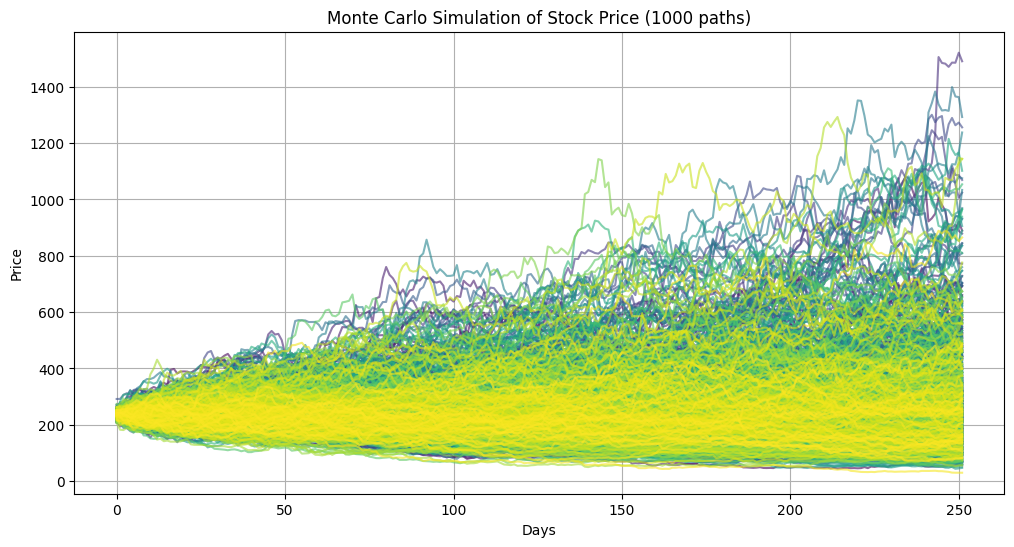

In [19]:
#Monte Carlo simulation parameters
num_simulations = 1000
num_days = 252  # 1 trading year
last_price = data['Close'].iloc[-1]

#Run the simulation
simulations = np.zeros((num_days, num_simulations))

for i in range(num_simulations):
    simulated_returns = np.random.choice(data['Daily Return'].dropna(), size=num_days, replace=True)
    
    price_path = np.zeros(num_days)
    price = last_price

    for t in range(num_days):
        price *= (1 + simulated_returns[t])
        price_path[t] = price

    simulations[:, i] = price_path



    
#Plot
plt.figure(figsize=(12, 6))

# Use a colormap
colors = cm.viridis(np.linspace(0, 1, num_simulations))

for i in range(num_simulations):
    plt.plot(simulations[:, i], color=colors[i], alpha=0.6)

plt.title(f'Monte Carlo Simulation of Stock Price ({num_simulations} paths)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [20]:
#Descriptive statistics of simulations
simulations_pd = pd.DataFrame(simulations)
print(simulations_pd.describe())

              0           1           2           3           4           5    \
count  252.000000  252.000000  252.000000  252.000000  252.000000  252.000000   
mean   147.453088  258.739645  101.800264  300.605965  162.671285  273.040013   
std     50.022487   34.983995   50.046659   38.071148   39.005755   43.224129   
min     73.042574  188.341653   44.980417  215.704597  107.356661  179.965331   
25%    108.528880  233.325987   56.801434  268.313486  136.260246  247.102735   
50%    127.266430  261.346197   89.857483  304.888860  151.001402  266.602482   
75%    196.856059  282.421028  132.750638  329.636470  188.071859  300.656554   
max    246.388855  348.853026  238.089082  381.080482  272.980456  405.738413   

              6           7           8           9    ...         990  \
count  252.000000  252.000000  252.000000  252.000000  ...  252.000000   
mean   350.794377  189.382143  248.744312  284.649612  ...  211.481933   
std     70.489348   28.702546   46.604584   69.6

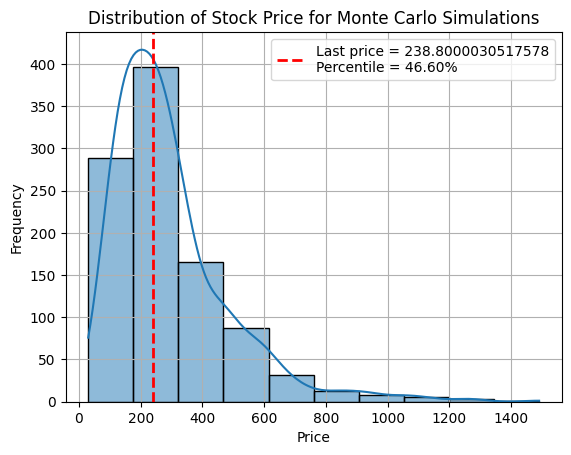

In [21]:

# Get the final price of each simulation
end_prices = simulations[-1, :]  # This is a NumPy array of final prices

# If you specifically want a list:
end_prices_list = end_prices.tolist()

value = data['Close'][-1]
percentile = percentileofscore(end_prices_list, value)

sns.histplot(end_prices_list, bins=10, stat='count', kde=True)
plt.axvline(value, color='red', linestyle='--', linewidth=2, label=f'Last price = {value}\nPercentile = {percentile:.2f}%')
plt.title(f'Distribution of Stock Price for Monte Carlo Simulations')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

From the distribution of stock prices for Monte Carlo Simulations, we can infer that about 46% of the simulated prices are less than the last recorded price, while about 54% of the simulated prices are greater than the last recorded price.

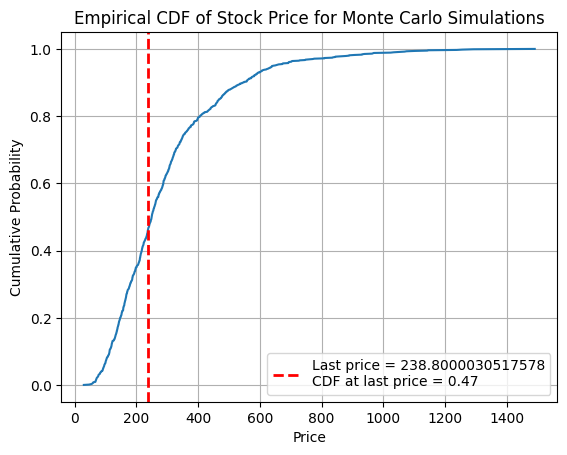

In [22]:
#CDF

#Sort the data
sorted_simulations = np.sort(end_prices_list)

#Calculate cumulative probabilities
cumulative_probabilities = np.arange(1, len(sorted_simulations) + 1) / len(sorted_simulations)

#Plot the CDF
result = ecdf(end_prices_list)
cdf_at_last_price = result.cdf.evaluate(value)


plt.plot(sorted_simulations, cumulative_probabilities)
plt.axvline(value, color='red', linestyle='--', linewidth=2, label=f'Last price = {value}\nCDF at last price = {cdf_at_last_price:.2f}')
plt.xlabel("Price")
plt.ylabel("Cumulative Probability")
plt.title("Empirical CDF of Stock Price for Monte Carlo Simulations")
plt.legend()
plt.grid(True)
plt.show()

The above graph show a CDF (Cummulative Density Function), which represent the probability that a variable take on a value less than or equal to a given value (in this case, that is the last price). The graph also supports that the last recorded price is greater than about 46% of the simulated prices.

From the distribution and the CDF of the stock price for Monte Carlo Simulations, we can infer with about 46% confidence level that there will be loss, while we can infer with 54% level that there will be profit after 1 trading year since the last recorded price. 

We can rigorously find the expected return after one year of trading. The expected value formula for the return relative to the last price is represented as E(X-x) = sum(p(X_i)*(X_i-x)), where x is the last price, X_i is a value from the simulations, and p(X_i) is the probability of X_i appearing in the simulations, which is 1/len(simulations) because the Monte Carlo simulations give discrete and uniformly distribution, meaning each value in the simulations has the same probability of appearing. The reason why the histogram plot show a "curved" distribution instead of a uniform distribution is because it is just a visualization from a distribution of intervals not single values. The formula for the return is then modified as E(X-x) = 1/len(simulations)*sum(X_i-x), which is equivalent to E(X-x) = mean(X_i - x).   

In [23]:
#Expected value for the profit/loss after 1 year of trading
X = end_prices_list
original_price = data['Close'][-1]
profit_loss = X - original_price

# Expected value over all outcomes
expected_value = np.mean(profit_loss)

print(f"Expected value of profit/loss: {expected_value:.2f}")

Expected value of profit/loss: 57.35


Since the expected value is positive, it might be favorable to hold the stock for 1 year, expecting a profit.

# Trading Algorithm

## Define Functions

In [24]:
def monte_carlo_sim(last_price_date, num_days):
    """
    Perform Monte Carlo Simulation to simulate future prices based on a selected date

    Parameters:
        last_price_date: the date index of the price we want to start with
        num_days: number of days we want to simulate the price for
    Return:
        an array of simulated prices
    """
    
    num_simulations = 1000 
    last_price = data['Close'][last_price_date]
    
    #Run the simulation
    simulations = np.zeros((num_days, num_simulations))
    
    for i in range(num_simulations):
        simulated_returns = np.random.choice(data['Daily Return'][:last_price_date], size=num_days, replace=True)
        
        price_path = np.zeros(num_days)
        price = last_price
    
        for t in range(num_days):
            price *= (1 + simulated_returns[t])
            price_path[t] = price
    
        simulations[:, i] = price_path
    return simulations

In [25]:
def end_monte_carlo_sim(monte_carlo_sim):
    """
    Select the last simulated day from the Monte Carlo Simulations function
    """
    # Get the final price of each simulation
    end_prices = simulations[-1, :]  
    end_prices_list = end_prices.tolist()
    
    return end_prices_list

In [26]:
def signal(last_price_date, prices, threshold):
    """
    Signal to buy and hold or not
    Calculate expected return relative to the last price
    Parameters:
        prices: simulated prices
        last_price_date: date of the last price
    Return:
        1: buy the stock and hold for some amount of time
        0: dont do anything
    """
    last_price = data['Close'][last_price_date]
    X = prices
    profit_loss = X - last_price
    expected_value = np.mean(profit_loss)

    threshold = 0

    if expected_value > threshold:
        return 1
    else:
        return 0
    
    

## Hyperparameter Tuning

In [27]:
data_train = data[:math.floor(0.8*len(data))]
data_test = data[math.floor(0.8*len(data)):]


In [28]:
def trading_for_tuning(last_date, threshold):
    """
    Perform dummy trading, holding for 30 days on each time step
    Later be used in optimization
    Parameter:
        last recorded date before simulation
    Return:
        an array of signal
    """
    
    last_date = data_train.index.get_loc(last_date)
    
    list_signal = []
    
    
    for i in range(last_date, len(data_train) - 30):
        end_monte_carlo = end_monte_carlo_sim(monte_carlo_sim(last_date, 30))
        buy_signal = signal(last_date, end_monte_carlo, threshold)
        
        list_signal.append(buy_signal)
        last_date +=1
    return list_signal

In [29]:
#Prepare target variable
list_label = []

last_date = data_train.index.get_loc('2021-12-31')
for i in range(last_date, len(data_train) - 30):
    price_now = data_train['Close'][i]
    price_future = data_train['Close'][i+30]

    if price_future > price_now:
        list_label.append(1)
    else:
        list_label.append(0)
    

In [35]:
def objective(threshold):
    signals = trading_for_tuning('2021-12-31', threshold=threshold[0])
    return -accuracy_score(list_label, signals)  # Minimize negative accuracy

result = gp_minimize(
    func=objective,
    dimensions=[Real(-20, 20)],  # Search space
    n_calls=100,  # Number of evaluations
    random_state=42
)

best_threshold = result.x[0]
best_accuracy = -result.fun
print(f"Best threshold: {best_threshold:.4f} with accuracy: {best_accuracy:.4f}")


Best threshold: 11.8617 with accuracy: 0.5380


## Trading Test

In [32]:
data_test

Price,Close,High,Low,Open,Volume,Daily Return
Date,,,,,,
2024-08-02,117.230003,119.589996,113.610001,116.660004,12666600,0.083457
2024-08-05,121.300003,121.379997,106.209999,106.305000,11560100,0.034718
2024-08-06,122.639999,124.779999,120.910004,122.489998,6530100,0.011047
2024-08-07,121.489998,126.370003,121.410004,123.809998,7086600,-0.009377
2024-08-08,124.760002,125.900002,121.180000,122.110001,5212400,0.026916
...,...,...,...,...,...,...
2025-06-26,239.639999,239.832993,231.750000,232.649994,3202400,0.029912
2025-06-27,242.315002,242.630005,235.679993,239.705002,7324600,0.011163
2025-06-30,246.509995,247.080002,241.957993,244.300003,8089900,0.017312


In [36]:
def trading_test():
    list_return = []
    i = data.index.get_loc(data_test.index[0])  # starting index in full data
    end_index = i + len(data_test)

    while i + 30 < len(data):  # make sure future_date won't overflow
        sim_prices = end_monte_carlo_sim(monte_carlo_sim(i, 30))
        sig = signal(i, sim_prices, 11.8617)

        if sig == 1:
            entry_price = data['Close'].iloc[i]
            exit_price = data['Close'].iloc[i + 30]
            list_return.append(exit_price - entry_price)
            i += 30  # skip forward 30 days after entering a trade
        else:
            i += 1  # no trade, check next day

    return list_return


In [39]:
test = trading_test()
print('The total return for the trading algorithm is:', np.sum(test))

The total return for the trading algorithm is: 98.60999298095703


# Conclusion

In this project, we studied the Doordash's stocks from December 9, 2020 to July 3, 2025. There were three main stages: Exploratory Data Analysis (EDA), one trading year forecasting, and trading algorithm construction. 

For the EDA, it is found that Close, High, Low, and Open showed an upward trend, while Volume and Daily Return showed a constant fluctuation around a value, throughout the period. In closer investigation, the ADF test was performed, and the results show that only Volume and Daily Return were stationary. The Durbin-Watson test was performed, and the results suggest that only Daily Return had no autocorrelation (white noise). The distributions of all variables were not normal, according to the Shapiro-Wilk test. A data resampling was performed on every variables to assume normal distribution, according to the conditions of the Central Limit Theorem. Once the data was normal, confidence intervals were calculated. 

For one trading year forecasting, the study made use of the Monte Carlo Simulation, where the random input is the daily return rate. The closing price was simulated for one trading year (approximately 252 days) with 1000 paths. From the simulated prices distribution and the CDF of them, it can be inferred that more than half of the simulated prices will be greater than the last recorded price. Further calculation for the expected return after one year show a positive value, indicating that holding the stock for one year since the last recorded price will be profitable. 

For the trading algorithm, the process of Monte Carlo Simulation was deployed. The dataset for the closing prices was splitted into training set (80%) and testing set (20%). The algorithm was hyperparameter tuned on the training set to find the best value for the threshold that minimize the error in predicting the buying signals. After that, the tuned model was deployed in the real time trading on the testing set. The result show that the algorithm generated a positive return. 